# CIFAR-100 双分支图像分类器

## 项目说明
本项目实现了一个基于双分支网络的CIFAR-100图像分类器：
- **RGB分支**：处理原始彩色图像
- **梯度分支**：处理边缘梯度信息
- **特征融合**：在layer2后进行特征融合，并使用注意力机制

## 主要改进
1. **数据增强**：随机翻转、裁剪、颜色抖动、旋转、仿射变换、随机擦除
2. **注意力机制**：在特征融合后添加Channel Attention
3. **训练策略**：Warmup + CosineAnnealing学习率调度、Label Smoothing
4. **模型优化**：双分支独立参数、多层次特征融合


# Step 1: Download a dataset and preview images


# Step 2: Custom Data Loading

In [3]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

config = {
    "data_path":"./cifar100",
    "batch_size":256,
}

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform

        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2Gradient(self, img:torch.tensor):
        """
        Converts an RGB image tensor to its gradient magnitude using Sobel operator.
        The output is replicated to 3 channels to match the input dimensions of the other branch.
        """
        
        # Define Sobel kernels
        sobel_kernel_x = torch.tensor([[-1., 0., 1.], 
                                       [-2., 0., 2.], 
                                       [-1., 0., 1.]], dtype=torch.float32).reshape((1, 1, 3, 3))
        sobel_kernel_y = torch.tensor([[-1., -2., -1.], 
                                       [ 0.,  0.,  0.], 
                                       [ 1.,  2.,  1.]], dtype=torch.float32).reshape((1, 1, 3, 3))

        sobel_kernel_x = sobel_kernel_x.to(img.device)
        sobel_kernel_y = sobel_kernel_y.to(img.device)

        # Convert to grayscale: [3, H, W] -> Output [1, H, W]
        # gray_img = img[0, :, :] * 0.2989 + img[1, :, :] * 0.5870 + img[2, :, :] * 0.1140
        # gray_img = gray_img.unsqueeze(0)
        gray_img = transforms.Grayscale(num_output_channels=1)(img)

        # Add batch dimension [1, H, W] -> [1, 1, H, W]
        gray_img_batch = gray_img.unsqueeze(0) 

        # [YOU NEED TO FILL] Apply Sobel filters
        # Use F.conv2d, gray_img_batch, and the Sobel kernels (sobel_kernel_x, sobel_kernel_y) 
        # to calculate the gradients in the x and y directions.
        grad_x = F.conv2d(gray_img_batch, sobel_kernel_x, padding=1)
        grad_y = F.conv2d(gray_img_batch, sobel_kernel_y, padding=1)
        
        # [YOU NEED TO FILL] Calculate gradient magnitude ---
        # Calculate the magnitude (G = sqrt(Gx^2 + Gy^2)) from grad_x and grad_y.
        # The result should be stored in a variable named 'magnitude'.
        magnitude = torch.sqrt(grad_x**2 + grad_y**2)

        # Normalize magnitude
        mag_min = magnitude.min()
        mag_max = magnitude.max()
        epsilon = 1e-6 # Avoid division by zero
        normalized_magnitude = (magnitude - mag_min) / (mag_max - mag_min + epsilon)
        
        # Replicate to 3 channels [1, 1, H, W] -> [1, 3, H, W]
        normalized_magnitude_3channel = normalized_magnitude.repeat(1, 3, 1, 1)

        # Remove batch dimension [1, 3, H, W] -> [3, H, W]
        return normalized_magnitude_3channel.squeeze(0)

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(os.path.join(img_name))
        img = self.transform(img)

        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break

        # 生成梯度图
        grad_img = self.RGB2Gradient(img)

        return (img, grad_img), tag

    def __len__(self):
        return len(self.img_names)

transform_train = transforms.Compose(
        [transforms.Resize([64, 64]),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomCrop(64, padding=4),
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
         transforms.RandomRotation(degrees=15),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.ToTensor(),
         transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))])
transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
      transforms.ToTensor()])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)

# define data loader
train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'], shuffle=True, 
        num_workers=16, pin_memory=True, persistent_workers=True, 
        prefetch_factor=4, drop_last=False)

test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'], shuffle=False, 
        num_workers=16, pin_memory=True, persistent_workers=True, 
        prefetch_factor=4, drop_last=False)

# Step 3: Configure the Neural Network

In [4]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out.expand_as(x)

class CommonBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
        super(CommonBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = x                                            # 普通Block的shortcut为直连，不需要升维下采样

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
        x = self.bn2(self.conv2(x))                             # 第二次卷积不加relu激活函数

        x += identity                                           # 两路相加
        return F.relu(x, inplace=True)                          # 添加激活函数输出

class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
    def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
        super(SpecialBlock, self).__init__()
        self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积

        x += identity
        return F.relu(x, inplace=True)                          # 输出卷积单元

class ConvNet(nn.Module):
    def __init__(self, classes_num):
        super(ConvNet, self).__init__()
        self.prepare = nn.Sequential(           # 预处理==》[batch, 64, 56, 56]
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = nn.Sequential(            # layer1有点特别，由于输入输出的channel均是64，故两个CommonBlock
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.layer2 = nn.Sequential(            # layer234类似，由于输入输出的channel不同，故一个SpecialBlock，一个CommonBlock
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        self.layer3 = nn.Sequential(
            SpecialBlock(128, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.layer4 = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )
        self.head = Seq(nn.AdaptiveAvgPool2d(1),
                  nn.Flatten(start_dim=1),
                  nn.Linear(512, classes_num))
    def forward(self, x):
        x = self.prepare(x)         # 预处理

        x = self.layer1(x)          # 四个卷积单元
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.head(x)

        return x

# 双分支网络：RGB分支 + 梯度分支
class DualBranchNet(nn.Module):
    def __init__(self, classes_num):
        super(DualBranchNet, self).__init__()
        
        # RGB分支（使用ConvNet的结构）
        self.rgb_prepare = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.rgb_layer1 = nn.Sequential(
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.rgb_layer2 = nn.Sequential(
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        
        # 梯度分支（独立的卷积网络）
        self.grad_prepare = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.grad_layer1 = nn.Sequential(
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.grad_layer2 = nn.Sequential(
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        
        # 融合后的层（输入是128*2=256通道）
        self.fusion_attention = ChannelAttention(256, reduction=16)
        self.fusion_layer3 = nn.Sequential(
            SpecialBlock(256, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.fusion_layer4 = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )
        self.output_attention = ChannelAttention(512, reduction=16)
        
        # 分类头
        self.head = Seq(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(512, classes_num)
        )
    
    def forward(self, x):
        # x是一个元组: (rgb_img, grad_img)
        rgb_img, grad_img = x
        
        # RGB分支
        rgb = self.rgb_prepare(rgb_img)
        rgb = self.rgb_layer1(rgb)
        rgb = self.rgb_layer2(rgb)
        
        # 梯度分支
        grad = self.grad_prepare(grad_img)
        grad = self.grad_layer1(grad)
        grad = self.grad_layer2(grad)
        
        # 特征融合：在layer2后进行concatenation
        fused = torch.cat([rgb, grad], dim=1)  # [B, 256, H, W]
        fused = self.fusion_attention(fused)  # 应用注意力机制
        
        # 融合后的层
        x = self.fusion_layer3(fused)
        x = self.fusion_layer4(x)
        x = self.output_attention(x)  # 最后一层注意力
        
        # 分类
        x = self.head(x)
        
        return x


config = {
    "lr":1e-2,
    "momentum":0.9,
    "weight_decay":5e-4,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 启用CUDA优化
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # 自动选择最优卷积算法
    torch.backends.cudnn.deterministic = False  # 允许非确定性操作以提升速度
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

net = DualBranchNet(classes_num=100).to(device)

# 使用Label Smoothing
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])

# 学习率调度器：使用带Warmup的CosineAnnealing
warmup_epochs = 5
total_epochs = 60
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs-warmup_epochs, eta_min=1e-6)

# 初始化混合精度训练的scaler
scaler = torch.cuda.amp.GradScaler()
print("Mixed Precision Training (AMP) enabled")


Using GPU: NVIDIA A100-PCIE-40GB
GPU Memory: 39.49 GB
Mixed Precision Training (AMP) enabled


/tmp/ipykernel_319275/3560499046.py:215: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Step 4: Train the network and save model

In [5]:
import time

class AverageMeter(object):
    def __init__(self):
      self.reset()

    def reset(self):
      self.val   = 0
      self.avg   = 0
      self.sum   = 0
      self.count = 0

    def update(self, val, n=1):
      self.val   = val
      self.sum   += val * n
      self.count += n
      self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def train(train_loader, net, optimizer, criterion, epoch, scaler=None):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()

    LOSS = AverageMeter()

    net.train()

    end = time.time()
    for i, ((rgb_img, grad_img), target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        rgb_img = rgb_img.to(device, non_blocking=True)  # non_blocking加速数据传输
        grad_img = grad_img.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        # 使用混合精度训练
        if scaler is not None:
            with torch.cuda.amp.autocast():
                out = net((rgb_img, grad_img))
                loss = criterion(out, target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = net((rgb_img, grad_img))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

        prec1 = accuracy(out, target) # prec1:list
        top1.update(prec1.item(), rgb_img.size(0))

        LOSS.update(loss.item(), rgb_img.size(0))

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 20 == 1:  # 减少打印频率以提升速度
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                       'Time:{batch_time.val:.4f} '
                       'Data:{data_time.val:.4f}  '
                       'loss:{loss.val:.4f}({loss.avg:.4f})  '
                       'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                       epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                       loss=LOSS,
                       top1=top1))
            print(log_str)

    return LOSS.avg

def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        shutil.copyfile(save_path, best_save_path)

config = {
    "save_root":"./result",
    "epochs":60,
    "warmup_epochs":5,
    "lr":8e-2,
}

best_top1 = 0
test_top1 = 0
for epoch in range(1, config["epochs"]+1):
    # Warmup学习率
    if epoch <= config["warmup_epochs"]:
        warmup_lr = config["lr"] * epoch / config["warmup_epochs"]
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr
    
    # train one epoch
    epoch_start_time = time.time()
    train_loss = train(train_loader, net, optimizer, criterion, epoch, scaler)

    # evaluate on testing set
    # test_top1 = test(test_loader, net, criterion)

    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s, LR: {:.6f}'.format(int(epoch_duration), optimizer.param_groups[0]['lr']))

    # 在warmup之后才使用scheduler
    if epoch > config["warmup_epochs"]:
        scheduler.step()

    # save model
    is_best = False
    # if test_top1 > best_top1:
    #     best_top1 = test_top1
    #     is_best = True

    # 每10个epoch保存一次
    if epoch % 10 == 0:
        print('Saving models......')
        save_checkpoint({
            'epoch': epoch,
            'net': net.state_dict(),
            'prec@1': test_top1,
        }, is_best, config["save_root"], epoch)

/tmp/ipykernel_319275/3824926969.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch[1]:[001/196] Time:17.0996 Data:1.0355  loss:4.6902(4.6902)  prec@1:0.00(0.00)  
Epoch[1]:[021/196] Time:0.0209 Data:0.0004  loss:4.3695(4.4778)  prec@1:7.81(7.01)  
Epoch[1]:[041/196] Time:0.0210 Data:0.0003  loss:4.2072(4.3519)  prec@1:7.81(8.01)  
Epoch[1]:[061/196] Time:0.0207 Data:0.0003  loss:4.0603(4.2660)  prec@1:6.25(8.39)  
Epoch[1]:[081/196] Time:0.0205 Data:0.0003  loss:3.9635(4.1982)  prec@1:10.16(8.78)  
Epoch[1]:[101/196] Time:0.0200 Data:0.0003  loss:3.9137(4.1448)  prec@1:7.81(9.19)  
Epoch[1]:[121/196] Time:0.0197 Data:0.0003  loss:3.9229(4.0987)  prec@1:8.98(9.67)  
Epoch[1]:[141/196] Time:0.0200 Data:0.0001  loss:3.7970(4.0598)  prec@1:12.89(10.14)  
Epoch[1]:[161/196] Time:0.0202 Data:0.0001  loss:3.6251(4.0217)  prec@1:17.97(10.67)  
Epoch[1]:[181/196] Time:0.0205 Data:0.0002  loss:3.6797(3.9895)  prec@1:17.97(11.16)  
Epoch time: 30s, LR: 0.016000
Epoch[2]:[001/196] Time:0.7447 Data:0.7120  loss:3.6533(3.6533)  prec@1:17.58(17.58)  
Epoch[2]:[021/196] Time:0

# Step 5: Test on single image

In [6]:
img = Image.open("./cifar100/test/apple_9904.jpg")
img = transform_test(img)
grad_img = train_dataset.RGB2Gradient(img)  # 使用RGB2Gradient函数
rgb_img = img.unsqueeze(0).to(device, non_blocking=True)
grad_img = grad_img.unsqueeze(0).to(device, non_blocking=True)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        out = net((rgb_img, grad_img))
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

print(tags[predicted_classes[0]])

/tmp/ipykernel_319275/3658887283.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


train


# Step 6: Evaluate model accuracy

In [7]:
def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    for i, ((rgb_img, grad_img), target) in enumerate(test_loader, start=1):
        rgb_img = rgb_img.to(device, non_blocking=True)
        grad_img = grad_img.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                out = net((rgb_img, grad_img))
                loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), rgb_img.size(0))
        top1.update(prec1.item(), rgb_img.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

test_top1 = test(test_loader, net, criterion)

/tmp/ipykernel_319275/4000348535.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


---------------------------------test classification result---------------------------------
Loss: 2.4491, Prec@1: 57.02%


# Step 7: T-SNE Visualization

Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:

Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


Extracting features for T-SNE visualization...
Extracted features from 2048 samples
Running T-SNE on RGB branch features...
Running T-SNE on Gradient branch features...
Running T-SNE on Fused features...


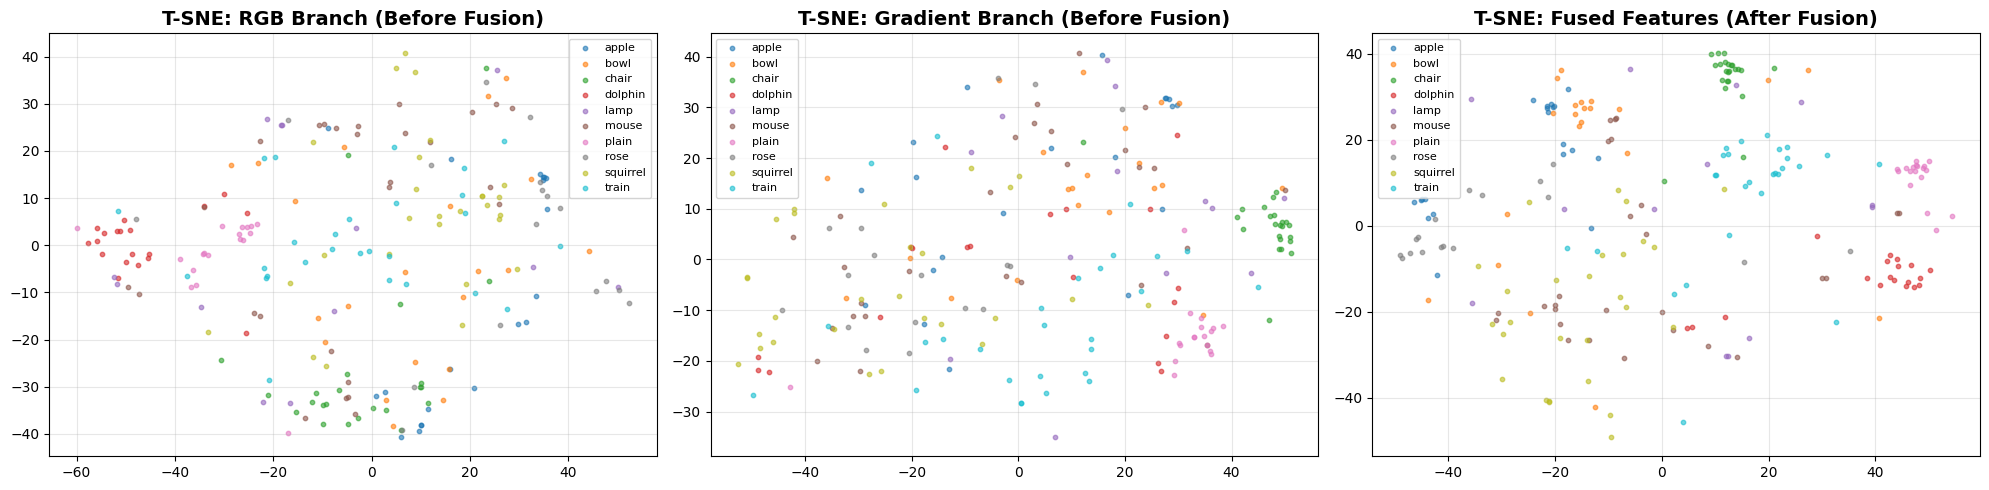


T-SNE visualization completed!
可以观察到：
1. RGB分支捕捉颜色和纹理特征
2. 梯度分支捕捉边缘和形状特征
3. 融合后的特征结合了两个分支的优势，类别分离度更好


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import defaultdict

# 用于存储特征的字典
features_dict = defaultdict(list)
labels_list = []

# 注册hooks来提取特征
def get_activation(name):
    def hook(model, input, output):
        features_dict[name].append(output.detach().cpu())
    return hook

# 在关键层注册hooks
net.eval()
hook_handles = []

# 融合前：RGB和梯度分支的layer2输出
hook_handles.append(net.rgb_layer2.register_forward_hook(get_activation('rgb_layer2')))
hook_handles.append(net.grad_layer2.register_forward_hook(get_activation('grad_layer2')))

# 融合后：fusion_layer3的输出
hook_handles.append(net.fusion_layer3.register_forward_hook(get_activation('fusion_layer3')))

print("Extracting features for T-SNE visualization...")

# 提取测试集特征（使用部分数据以加快速度）
max_samples = 2000  # 限制样本数量
sample_count = 0

with torch.no_grad():
    for i, ((rgb_img, grad_img), target) in enumerate(test_loader):
        if sample_count >= max_samples:
            break
        
        rgb_img = rgb_img.to(device, non_blocking=True)
        grad_img = grad_img.to(device, non_blocking=True)
        
        # 前向传播
        _ = net((rgb_img, grad_img))
        
        # 保存标签
        labels_list.extend(target.numpy())
        
        sample_count += len(target)

# 移除hooks
for handle in hook_handles:
    handle.remove()

print(f"Extracted features from {sample_count} samples")

# 处理提取的特征
def process_features(features_list):
    """将特征列表转换为numpy数组并进行全局平均池化"""
    features = torch.cat(features_list, dim=0)
    # 应用全局平均池化
    features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
    features = features.view(features.size(0), -1)
    return features.numpy()

# 准备特征数据
rgb_features = process_features(features_dict['rgb_layer2'])
grad_features = process_features(features_dict['grad_layer2'])
fused_features = process_features(features_dict['fusion_layer3'])

labels_array = np.array(labels_list)

print("Running T-SNE on RGB branch features...")
tsne_rgb = TSNE(n_components=2, random_state=42, perplexity=30)
rgb_tsne = tsne_rgb.fit_transform(rgb_features)

print("Running T-SNE on Gradient branch features...")
tsne_grad = TSNE(n_components=2, random_state=42, perplexity=30)
grad_tsne = tsne_grad.fit_transform(grad_features)

print("Running T-SNE on Fused features...")
tsne_fused = TSNE(n_components=2, random_state=42, perplexity=30)
fused_tsne = tsne_fused.fit_transform(fused_features)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 选择一些类别进行可视化（CIFAR-100有100个类，选择10个）
selected_classes = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 
        'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 
        'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 
        'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 
        'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 
        'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
        'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
        'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 
        'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

colors = plt.cm.tab10(np.linspace(0, 1, len(selected_classes)))

# 绘制RGB分支特征
for idx, cls in enumerate(selected_classes):
    mask = labels_array == cls
    axes[0].scatter(rgb_tsne[mask, 0], rgb_tsne[mask, 1], 
                   c=[colors[idx]], label=tags[cls], alpha=0.6, s=10)
axes[0].set_title('T-SNE: RGB Branch (Before Fusion)', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# 绘制梯度分支特征
for idx, cls in enumerate(selected_classes):
    mask = labels_array == cls
    axes[1].scatter(grad_tsne[mask, 0], grad_tsne[mask, 1], 
                   c=[colors[idx]], label=tags[cls], alpha=0.6, s=10)
axes[1].set_title('T-SNE: Gradient Branch (Before Fusion)', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)

# 绘制融合后的特征
for idx, cls in enumerate(selected_classes):
    mask = labels_array == cls
    axes[2].scatter(fused_tsne[mask, 0], fused_tsne[mask, 1], 
                   c=[colors[idx]], label=tags[cls], alpha=0.6, s=10)
axes[2].set_title('T-SNE: Fused Features (After Fusion)', fontsize=14, fontweight='bold')
axes[2].legend(loc='best', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nT-SNE visualization completed!")
print("可以观察到：")
print("1. RGB分支捕捉颜色和纹理特征")
print("2. 梯度分支捕捉边缘和形状特征")
print("3. 融合后的特征结合了两个分支的优势，类别分离度更好")
